# Szeregi czasowe

Szereg czasowy to sekwencyjny zbiór punktów danych gdzie kolejne pomiary odbywają się po sobie ze stałym krokiem czasowym. Otrzymane wartości pomiarów są ułożone w szeregu w porządku chronologicznym.

Szereg czasowy co do zasady jest niedeterministyczny, co oznacza, że nie jesteśmy w stanie w łatwy sposób określić modelu jakim podąża. Zbiór obserwacji szeregu czasowego możemy traktować jako realizację pewnego procesu stochastycznego, którego dziedziną jest czas.

Stosując różne techniki możemy poznać charakter szeregu i jego komponenty co pozwoli na przejście do etapu predykcji jego przyszłych wartości.

Przykłady szeregów czasowych:
- cogodzinny pomiar temperatury przez stację pogodową
- średnia cena energii elektrycznej w poszczególnych miesiącach
- liczba zgłaszanych przestępstw w poszczególnych latach

## Dlaczego szeregi czasowe są takie szczególne?
Dla lepszego zrozumienia czym różni się predykcja szeregów czasowych od klasycznego zadania regresji przeanalizujmy przykład firmy sprzedającej lody.

W klasycznym podejściu mamy dane historyczne, które przedstawiają sprzedaż lodów w zależności od temperatury. Wykorzystując dane trenujemy model, który dla zadanej temperatury będzie przewidywał liczbę sprzedanych lodów. W tym przypadku mamy do czynienia z zadaniem interpolacji, gdzie predykcja odbywa się wewnątrz pewnego przedziału.

W szeregach czasowych zakładamy, że istnieje pewne związanie między poprzednimi i kolejnymi wartościami (np. sprzedaż lodów dnia następnego i poprzedniego), które pozwoli na estymowanie kolejnych nieznanych punktów czasowych. W szeregach czasowych chcemy dokonać predykcji przyszłości - jest to zadanie ekstrapolacji. Pewność predykcji  maleje wraz z oddalaniem się od znanej historii.

Predykcja szeregów czasowych jest zwykle trudniejsza od klasycznego zadania regresji, jednak może dawać lepsze rezultaty, zwłaszcza w przewidywaniu w krótkim odstępie czasu.

## Komponenty szeregu czasowego
Szereg czasowy może (ale nie musi) zawierać następujące komponenty:
1. **Trend** - długofalowy kierunek szeregu czasowego
    - wzrost
    - spadek
    - brak trendu
2. **Sezonowość** - okresowa fluktuacja
3. **Komponent rezydualny** - niemożliwe do przewidzenia wartości zmiennej losowej
4. **Cykle** - wynikają z charakteru obserwowanego obiektu, np. dla spółki: wzrost, spadek, recesja, odbudowa
    - dłuższe niż sezonowość (mogą dziać się na przestrzeni wielu lat)
    - nie są tak przewidywalne jak sezonowość
    - mogą mieć różną długość

## Wstępne przetwarzanie
W niniejszym tutorialu wykorzystamy zbiór zawierający dane z systemu wypożyczania rowerów. Zbiór zawiera informacje na temat wypożyczeń rowerów każdego dnia na przestrzeni dwóch lat.

### Wczytanie i wizualizacja

In [3]:
library(anytime) 
suppressPackageStartupMessages(library(tidyverse))

# wczytanie
data <- read.csv('data/bike_sharing.csv', header=TRUE, stringsAsFactors=FALSE)

# konwersja stringa na date
data$date <- anydate(data$dteday)

# interesują nas tylko kolumny zawierające datę i liczbę wypożyczonych rowerów
data <- select(data, c("date", "cnt"))

head(data)

,date,cnt
,<date>,<int>
1,2011-01-01,985
2,2011-01-02,801
3,2011-01-03,1349
4,2011-01-04,1562
5,2011-01-05,1600
6,2011-01-06,1606


Wizualizacja analizowanego szeregu czasowego:

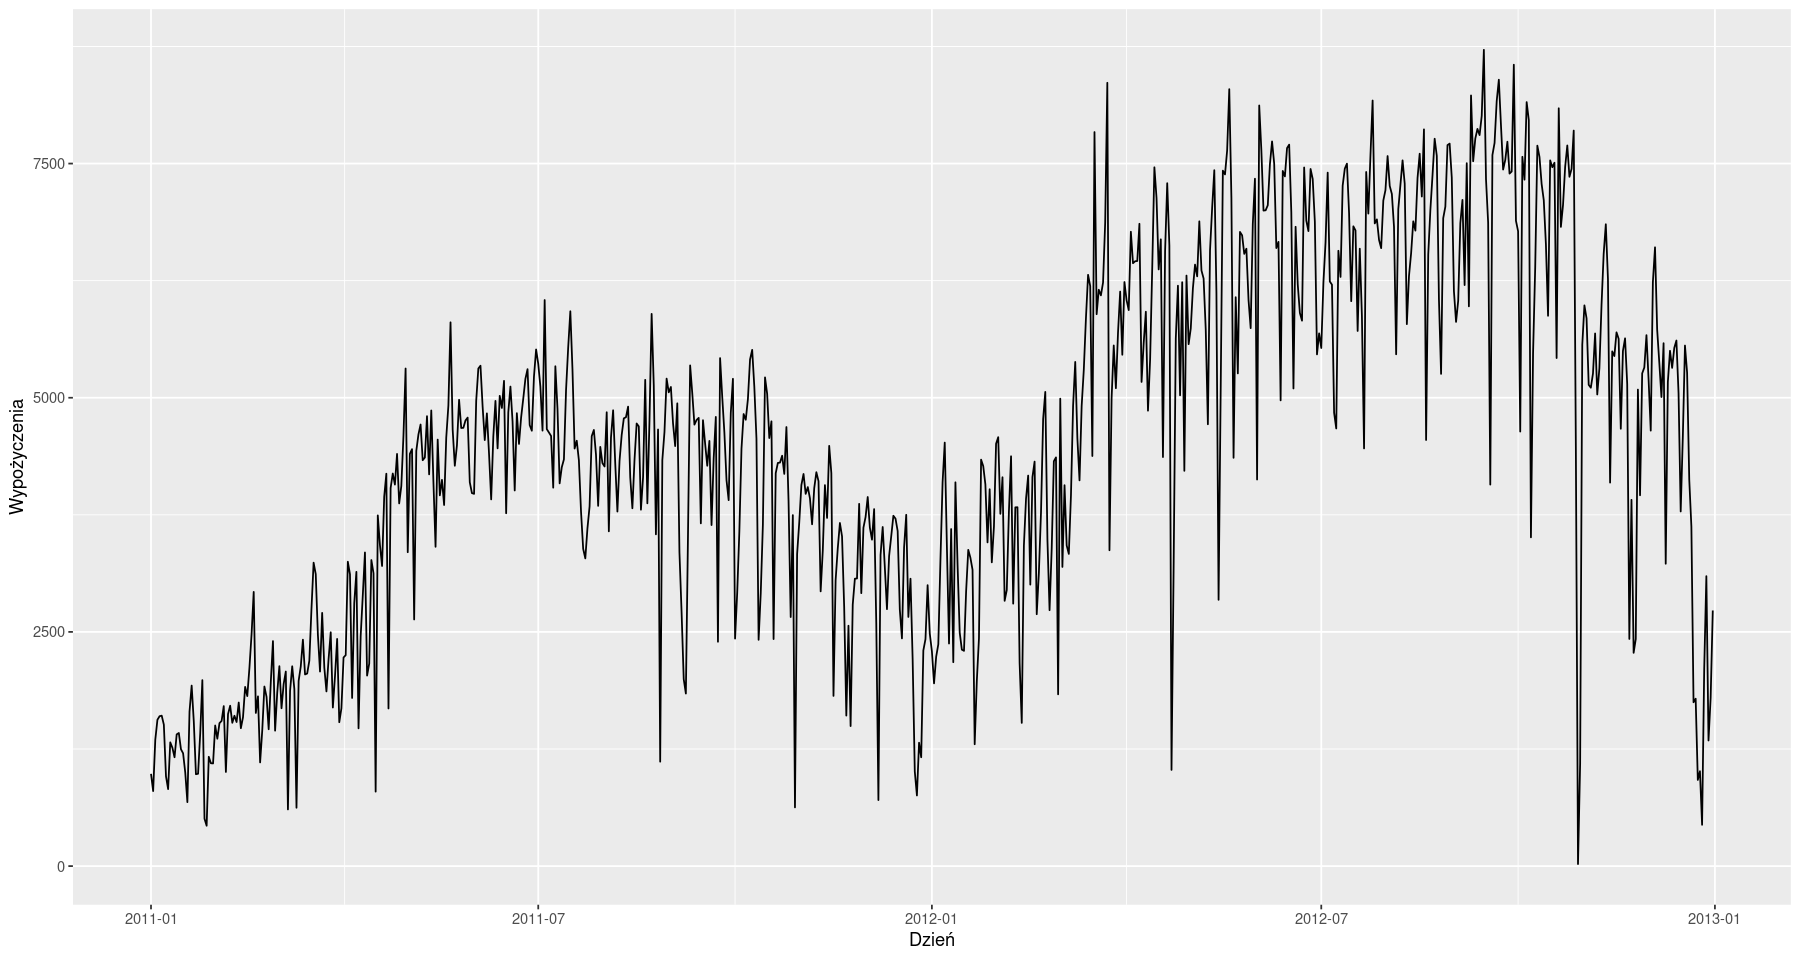

In [8]:
library(ggplot2)

# ustawienie rozmiaru wykresu
options(repr.plot.width=15, repr.plot.height=8)

ggplot(data, aes(date, cnt)) + 
    geom_line() + 
    xlab("Dzień") + 
    ylab("Wypożyczenia") +
    theme(text = element_text(size = 15))

### Czyszczenie danych

W pakiecie `forecast` dostępna jest funkcja `tsclean`, która w wygodny sposób pozwala na usunięcie obserwacji odstających i uzupełnienie brakujących wartości.

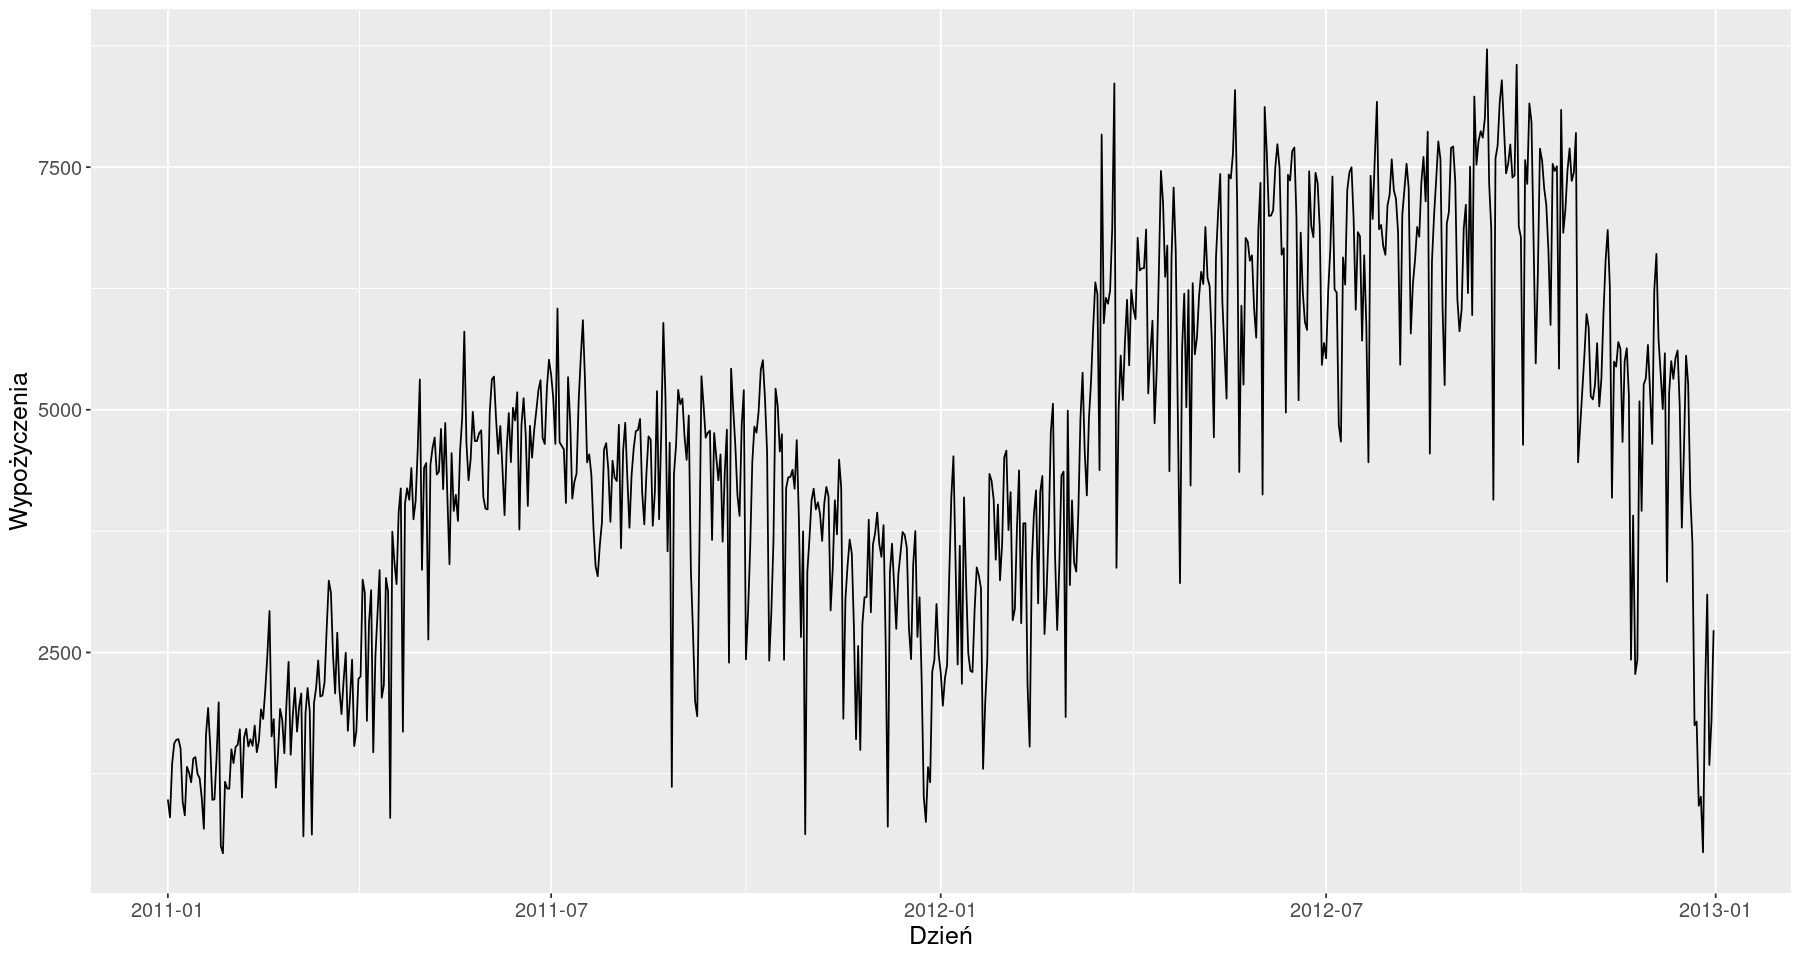

In [50]:
suppressPackageStartupMessages(library('forecast'))

data$clean_cnt = tsclean(data$cnt)
ggplot(data, aes(date, clean_cnt)) + 
    geom_line() + 
    xlab("Dzień") + 
    ylab("Wypożyczenia") +
    theme(text = element_text(size = 15))

### Wygładzanie danych
Pomimo usunięcia wartości odstających nasz szereg czasowy nadal charakteryzuje duża zmienność. Możemy poradzić sobie z tym problemem wygładzając dane poprzez zastosowanie średniej ruchomej. W ten sposób otrzymamy stabilniejszy, a przez to również bardziej przewidywalny szereg czasowy.

Warning message:
“Removed 6 row(s) containing missing values (geom_path).”


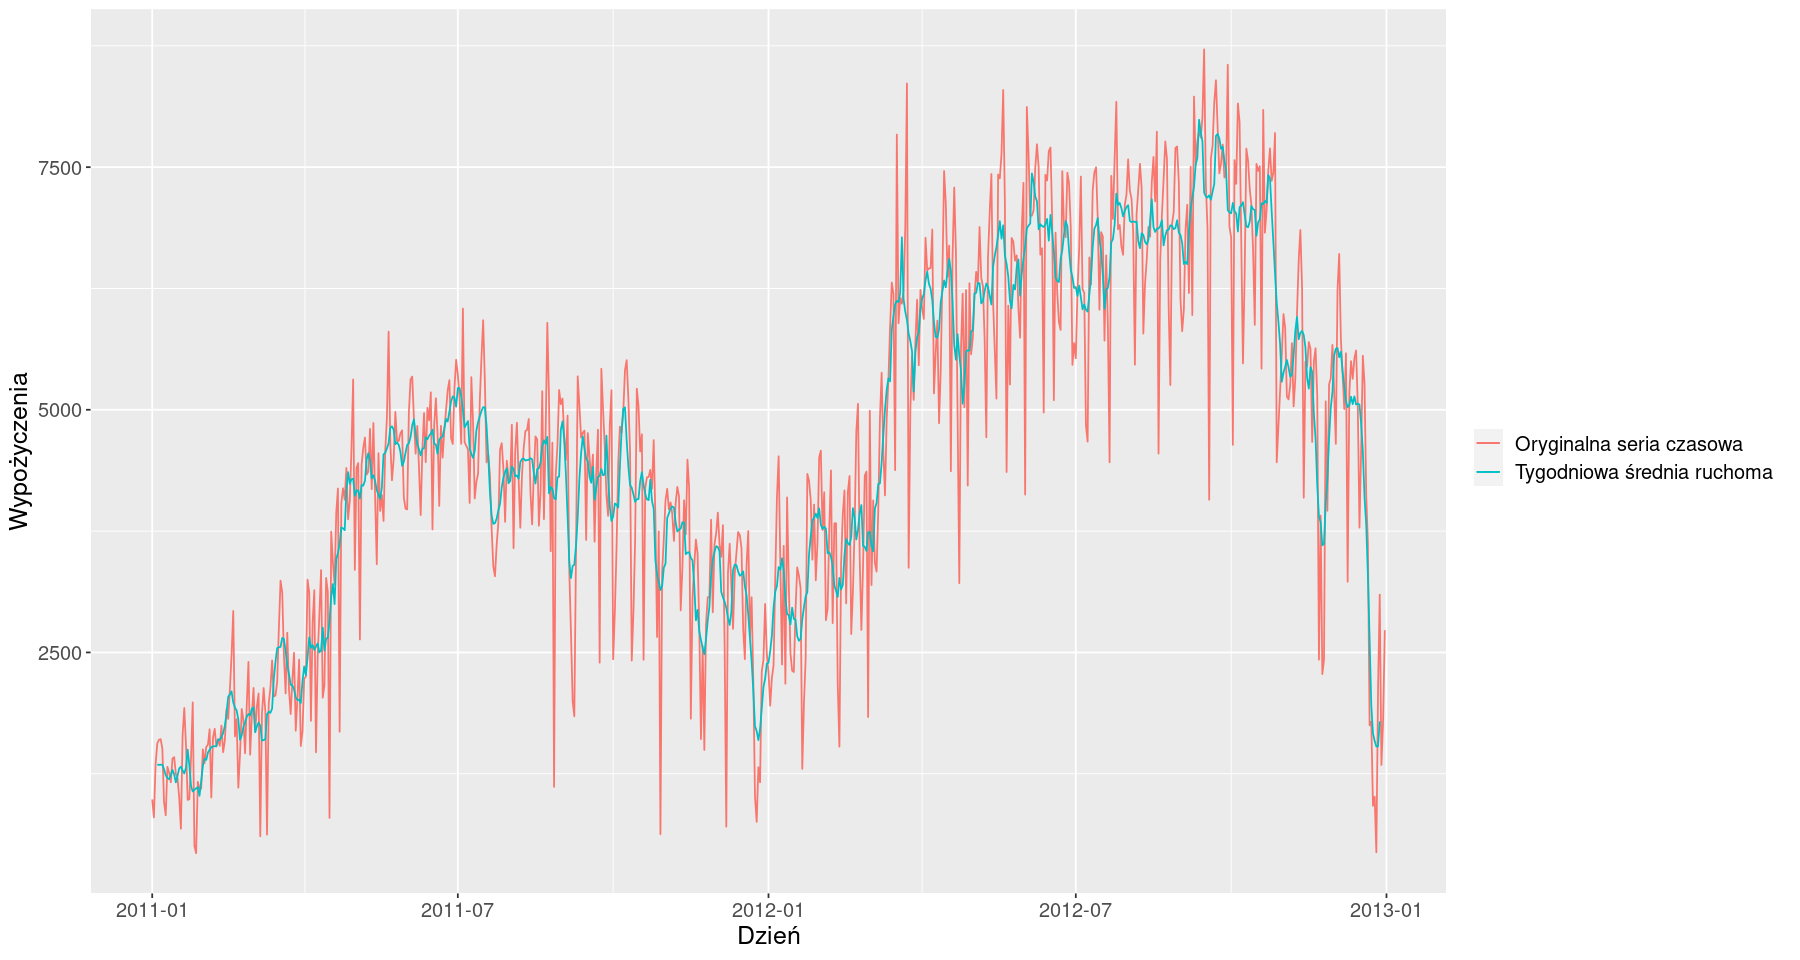

In [49]:
data$cnt_ma <- ma(data$clean_cnt, order = 7)

ggplot() + 
  geom_line(data = data, aes(x = date, y = clean_cnt, colour = "Oryginalna seria czasowa")) +
  geom_line(data = data, aes(x = date, y = cnt_ma, colour = "Tygodniowa średnia ruchoma")) +
  xlab("Dzień") + 
  ylab("Wypożyczenia") + 
  theme(text = element_text(size = 15), legend.title=element_blank())

### Dekompozycja szeregu czasowego

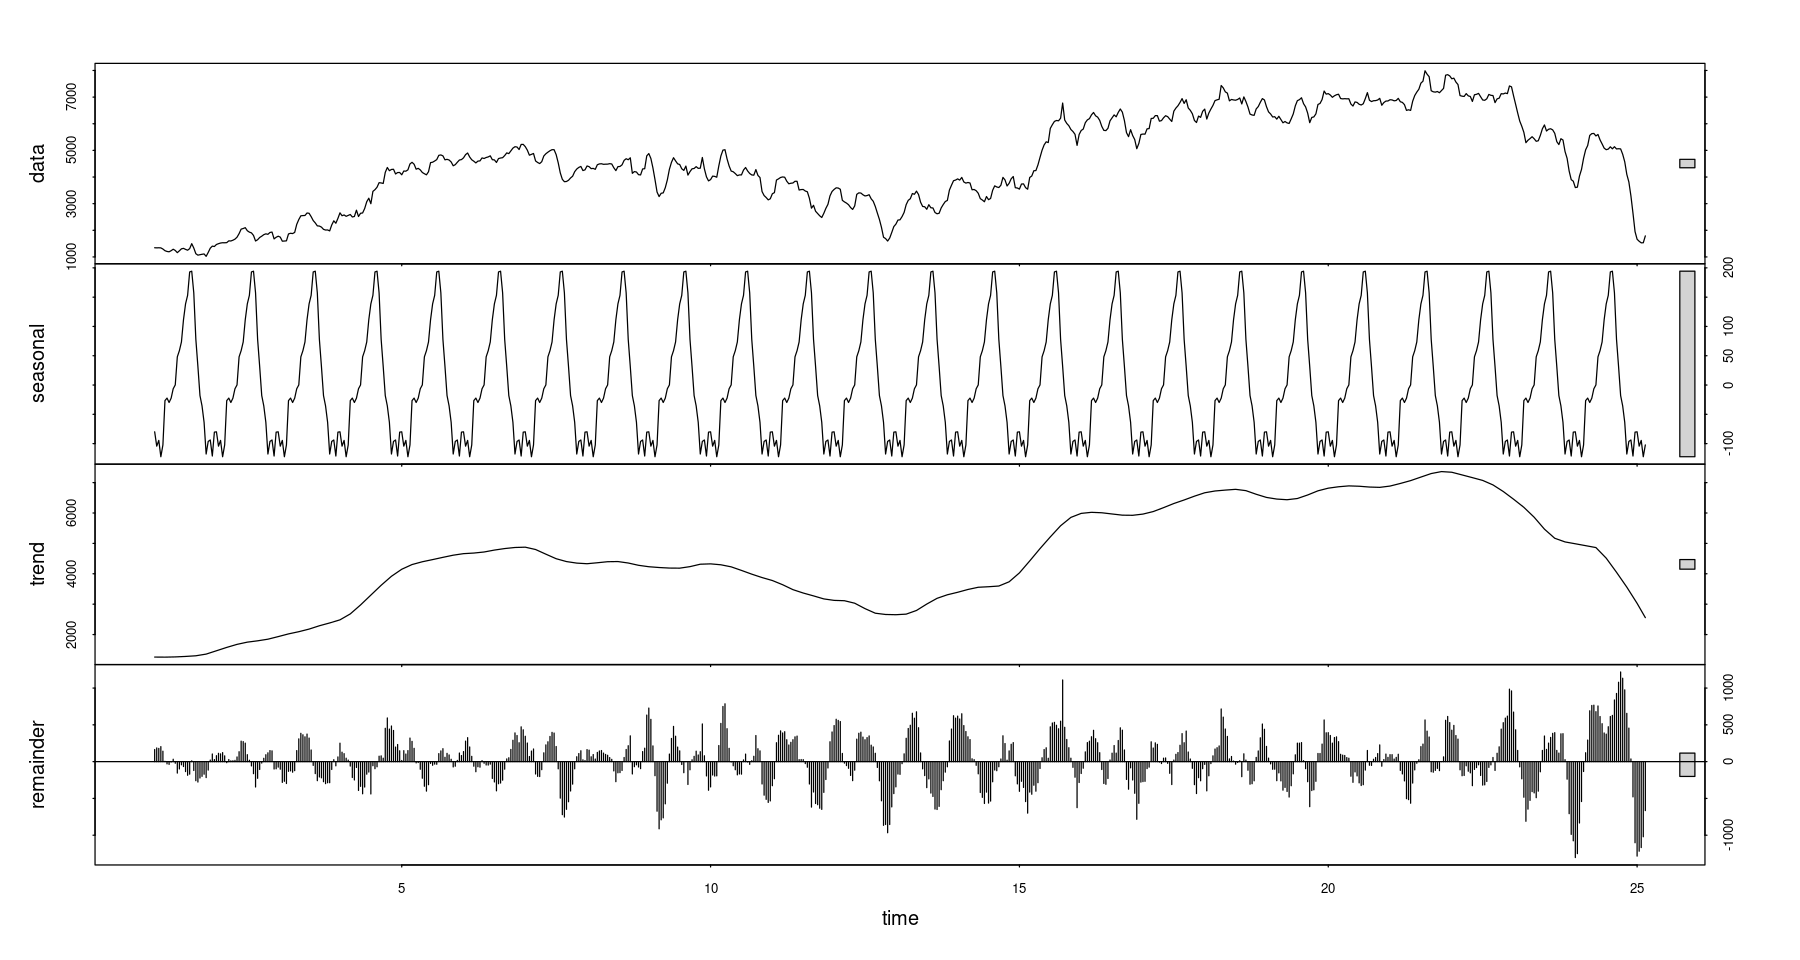

In [18]:
cnt = ts(na.omit(data$cnt_ma), frequency=30) 

# wyodrębnienie komponentów szeregu
decomp = stl(cnt, s.window="periodic")

# usunięcie komponentu sezonowego
deseasonal_cnt <- seasadj(decomp)

# wykres komponentów
plot(decomp)

### Stacjonarność szeregu czasowego
Wiele modeli (AR, MA, ARMA) wymagają, aby szereg był stacjonarny. Szereg czasowy jest stacjonarny gdy spełnia następujące warunki:
- stała wartość oczekiwana
- stałe odchylenie standardowe
- brak sezonowości

Do sprawdzenia stacjonarności możemy użyć rozszerzonego testu Dickeya–Fullera (*Augmented Dickey–Fuller test*).

In [19]:
library('tseries')

adf.test(deseasonal_cnt, alternative = "stationary")

Warning message in adf.test(deseasonal_cnt, alternative = "stationary"):
“p-value greater than printed p-value”



	Augmented Dickey-Fuller Test

data:  deseasonal_cnt
Dickey-Fuller = -0.18385, Lag order = 8, p-value = 0.99
alternative hypothesis: stationary


Uzyskana duża p-wartość pokazuje, że analizowany szereg nie jest stacjonarny.

Możemy uzyskać stacjonarność szeregu stosując operację różnicowania $Z_t = y_t - y_{t-k}$.

W ten sposób otrzymamy nowy szereg czasowy $Z_t$, który powstał przez odjęcie od każdego elementu sąsiedniego elementu oddalonego o $k$.

W naszym przypadku zacznijmy od $k=1$ i zobaczmy czy uzyskany szereg jest stacjonarny.

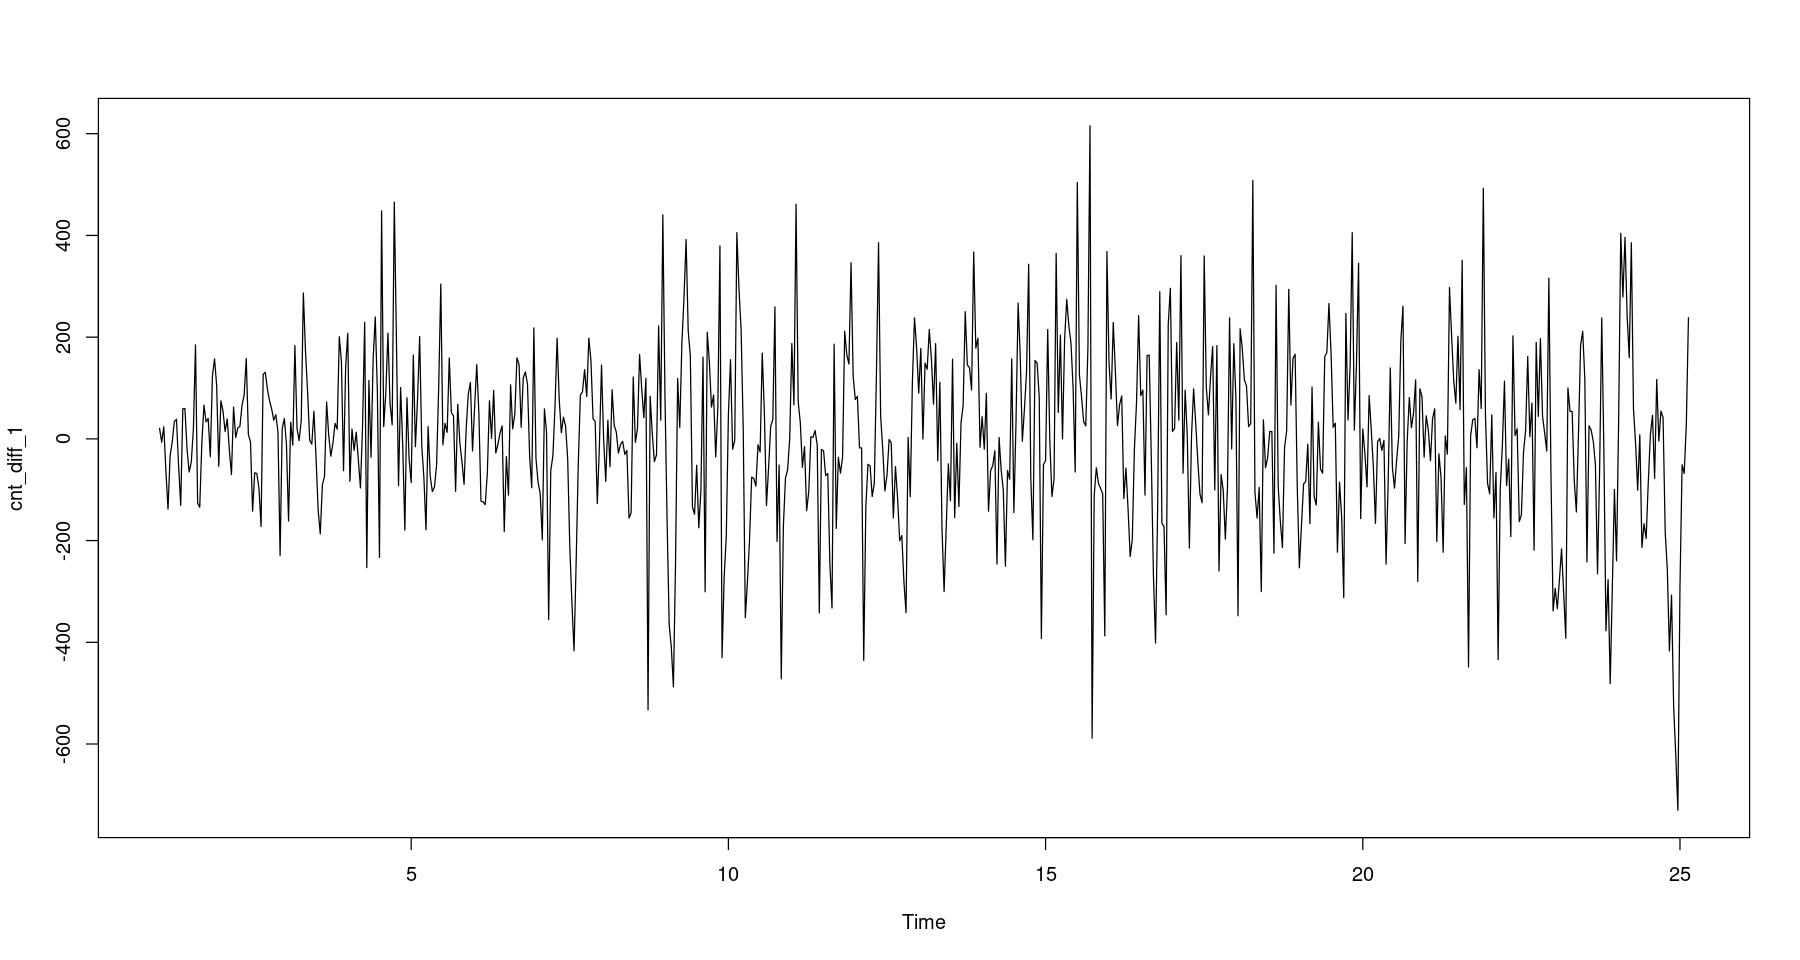

In [20]:
cnt_diff_1 = diff(deseasonal_cnt, differences = 1)
plot(cnt_diff_1, type="l")

In [21]:
adf.test(cnt_diff_1, alternative = "stationary")

Warning message in adf.test(cnt_diff_1, alternative = "stationary"):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  cnt_diff_1
Dickey-Fuller = -9.9255, Lag order = 8, p-value = 0.01
alternative hypothesis: stationary


Przeprowadzony test pozwolił odrzucić hipotezę zerową o niestacjonarności szeregu i przyjąć hipotezę alternatywną, że szereg jest stacjonarny.

## Analiza ACF i PACF
Autokorelacja (ACF) i częściowa autokorelacja (PACF):
- pozwalają na analizę trendu i sezonowości szeregu
- PACF bierze pod uwagę tylko bezpośredni wpływ $X_{t-k}$ na $X_t$
- ACF bierze pod uwagę bezpośredni oraz pośredni wpływ obserwacji na siebie
- ACF pozwala określić stopień $q$ modelu MA
- PACF pozwala określić stopień $p$ modelu AR

Dodatkowo na wykresach ACF i PACF można zauważyć obszar wyznaczony przez przerywane linie. Obszar ten przedstawia 95% przedział ufności. Wszystkie korelacje poza tym obszarem są statystycznie istotne.

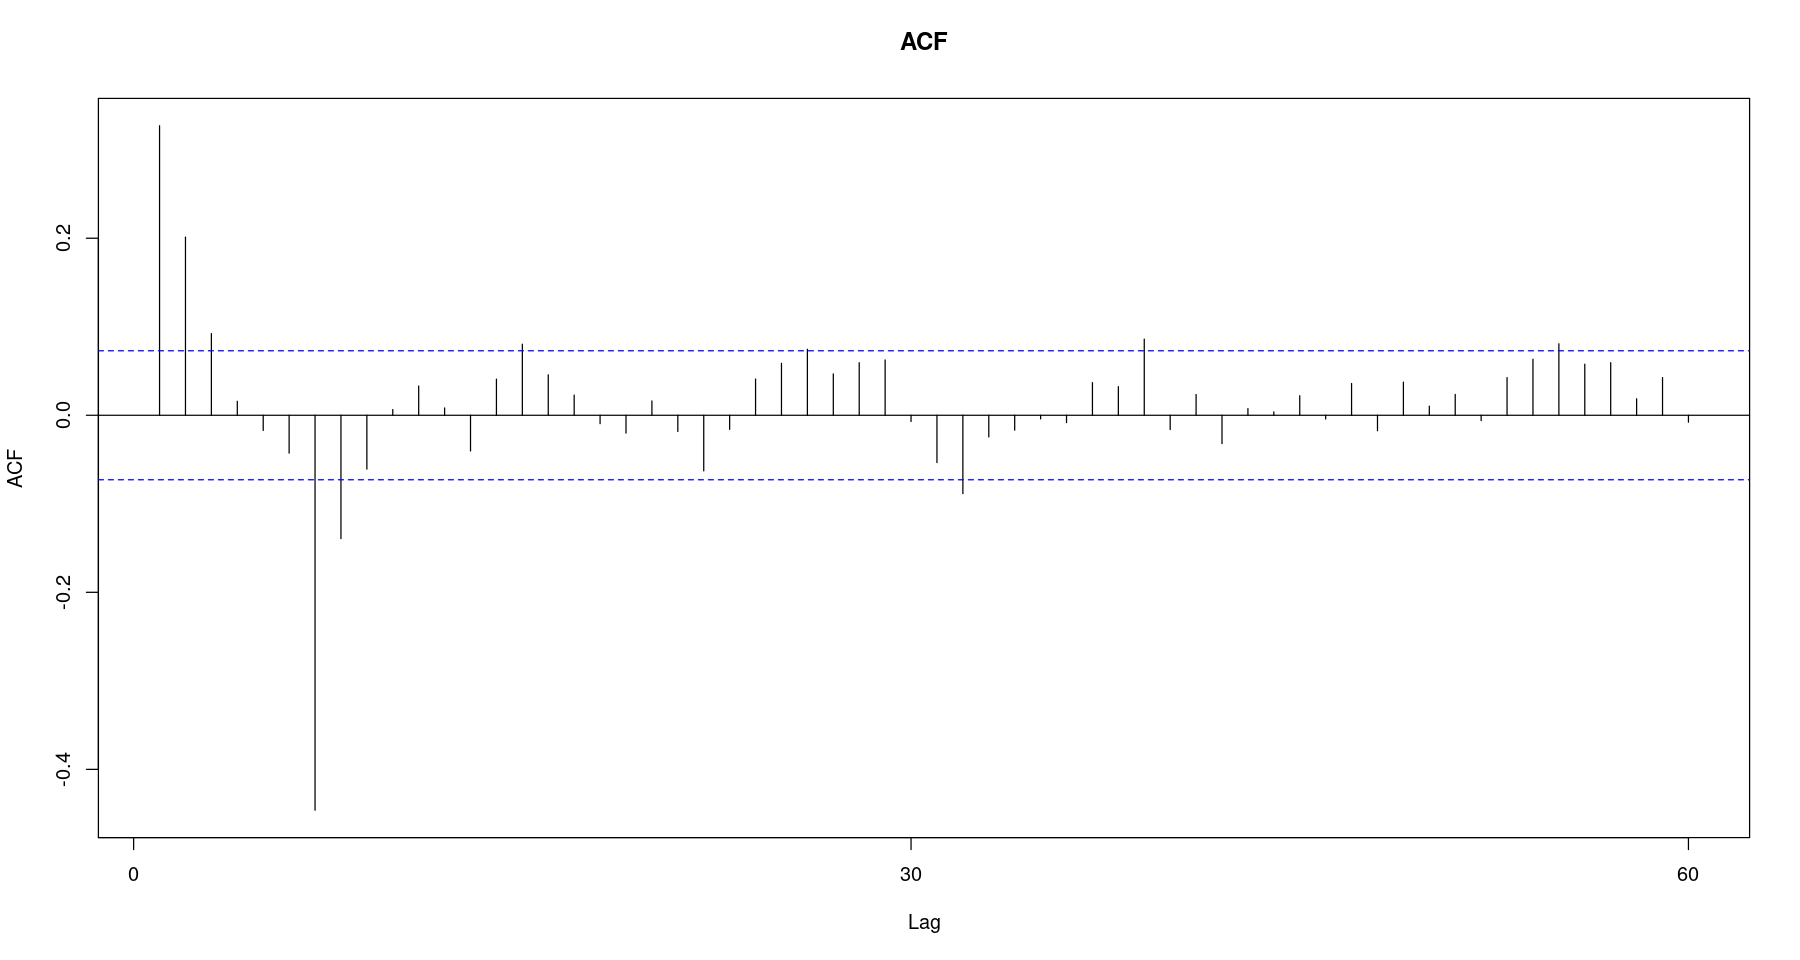

In [24]:
Acf(cnt_diff_1, main = "ACF")

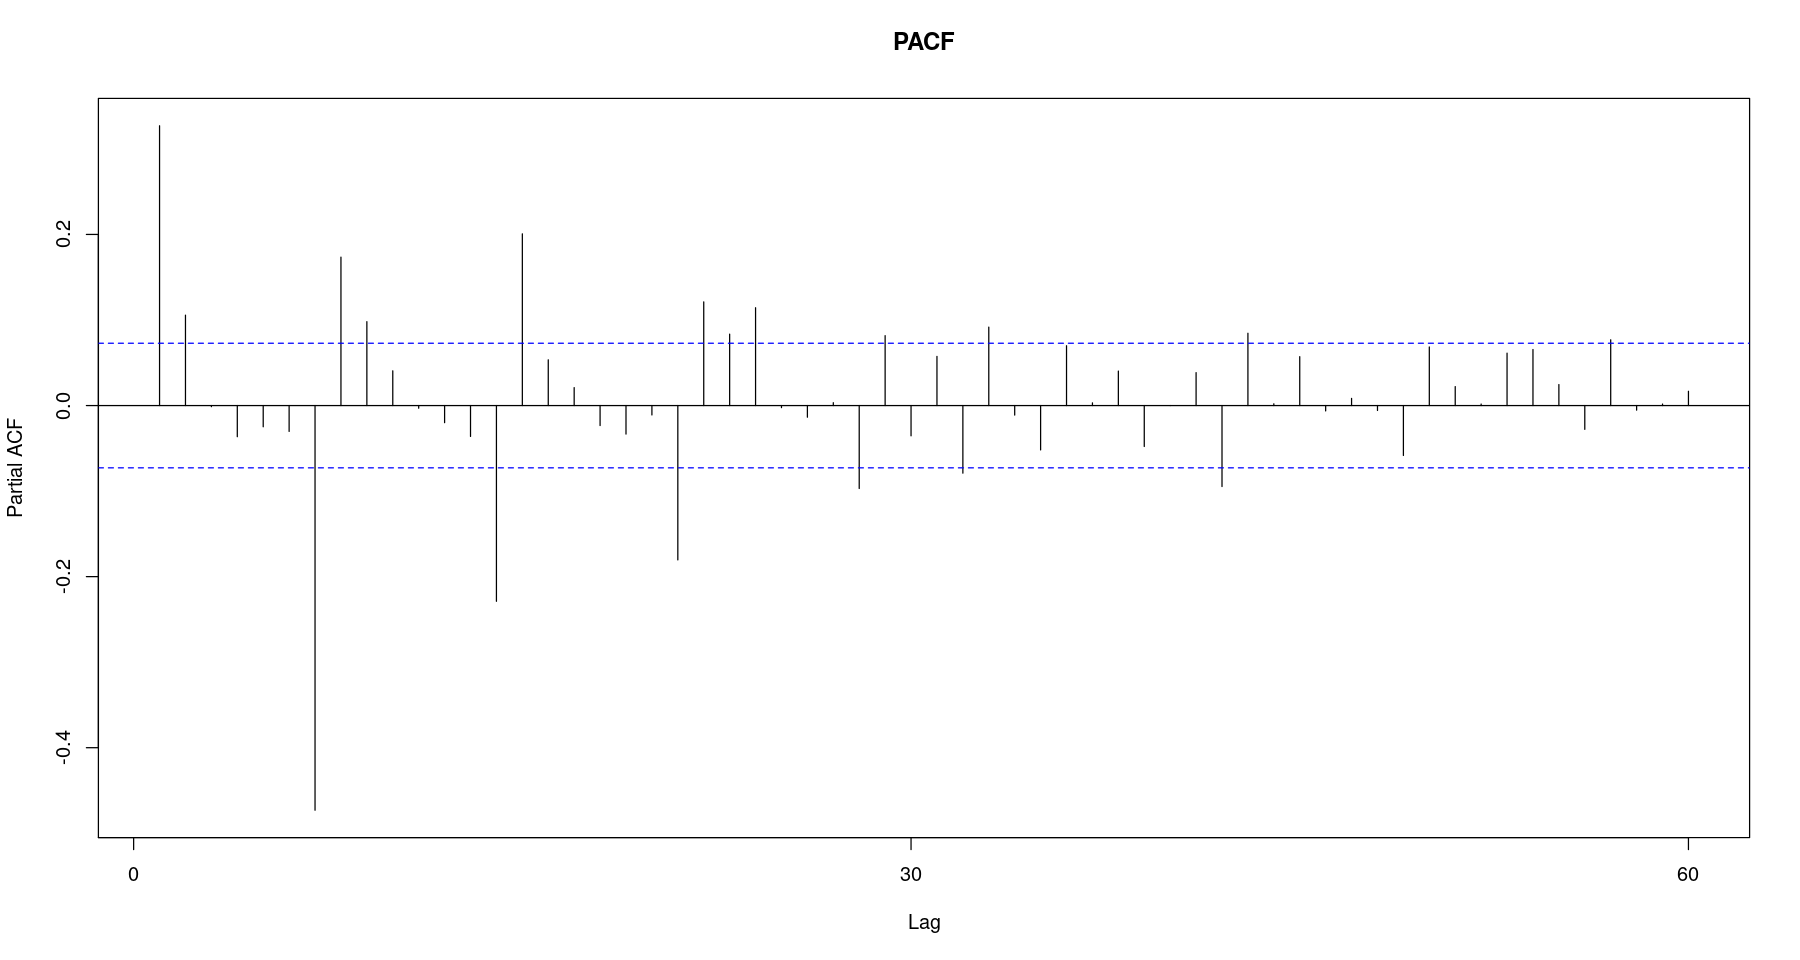

In [25]:
Pacf(cnt_diff_1, main = "PACF")

Wykres ACF pokazuje silną korelację dla lagów 1, 2 i 7. Na wykresie PACF widoczna jest silna korelacja dla lagów 1 i 7. Wykorzystując te informacje możemy przetestować model z komponentami AR lub MA stopnia 1,2 lub 7.

Dodatkowo warto zauważyć silne piki co 7 dni na wykresie PACF. Może to oznaczać tygodniową sezonowość. W takiej sytuacji warto również wypróbować model SARIMA, który ją uwzględni.

## Model ARIMA

Jednym z najczęściej wykorzystywanych modeli do predykcji szeregów czasowych jest model ARIMA (AutoRegressive Integrated Moving Average). Składa się on z 3 komponentów:
- **AR** - składnik autoregresyjny (stopień określany przez parametr *p*)
- **I** - składnik różnicujący (parametr *d* określa lag potrzebny do uzyskania stacjonarności)
- **MA** - składnik średniej ruchomej (stopień określany przez parametr *q*)

Dzięki składnikowi **I** szereg czasowy dostarczony modelowi ARIMA nie musi być stacjonarny, ale musimy być w stanie poprawnie określić parametr *d*.

Wytrenujemy teraz 4 modele ARIMA z różnymi parametrami określonymi na podstawie wykresów ACF/PACF:
- ARIMA ( 0, 1, 7 )
- ARIMA ( 1, 1, 7 )
- ARIMA ( 7, 1, 7 )
- ARIMA ( 1, 1, 1 )

Do treningu użyjemy pierwsze 700 obserwacji, a do testowania predykcji następne 25 obserwacji.

In [26]:
model_1 = arima(ts(deseasonal_cnt[-c(701:725)]), order=c(0,1,7))
model_2 = arima(ts(deseasonal_cnt[-c(701:725)]), order=c(1,1,7))
model_3 = arima(ts(deseasonal_cnt[-c(701:725)]), order=c(7,1,7))
model_4 = arima(ts(deseasonal_cnt[-c(701:725)]), order=c(1,1,1))

W celu wybrania modelu użyjemy **Akaike's Information Criteria (AIC)**, które poszukuje kompromisu pomiędzy złożonością modelu a jego dopasowaniem. AIC może być interpretowane jako oszacowanie, ile informacji zostałoby utraconych w przypadku wyboru danego modelu. Niższe AIC oznacza lepszy model.

In [27]:
AIC(model_1)
AIC(model_2)
AIC(model_3)
AIC(model_4)

[1] 8711.402

[1] 8691.533

[1] 8693.443

[1] 9083.729

Najlepszy wynik osiągnął model ARIMA (1, 1, 7).

Możemy również użyć funkcji `auto.arima`, która automatycznie postara się dopasować najlepsze parametry dla modelu. Ustawiając parametr `seasonal=TRUE` użyjemy modelu SARIMA.

In [28]:
auto.arima(deseasonal_cnt, seasonal = FALSE)

Series: deseasonal_cnt 
ARIMA(2,1,0) 

Coefficients:
         ar1     ar2
      0.2929  0.1055
s.e.  0.0370  0.0370

sigma^2 = 26137:  log likelihood = -4708.32
AIC=9422.64   AICc=9422.68   BIC=9436.4

In [29]:
auto.arima(deseasonal_cnt, seasonal = TRUE)

Series: deseasonal_cnt 
ARIMA(2,1,2)(1,0,0)[30] 

Coefficients:
         ar1      ar2      ma1     ma2    sar1
      1.3644  -0.8027  -1.2903  0.9146  0.0100
s.e.  0.0372   0.0347   0.0255  0.0202  0.0388

sigma^2 = 24810:  log likelihood = -4688.59
AIC=9389.17   AICc=9389.29   BIC=9416.68

`auto.arima` zwróciła trochę inne parametry, a wyniki zarówno dla modelu ARIMA jak i SARIMA są trochę gorsze niż dla modelu, którego parametry ustawialiśmy własnoręcznie. Nalezy jednak zauważyć, że uwzględnienie sezonowości dało lepszy rezultat.

## Predykcja

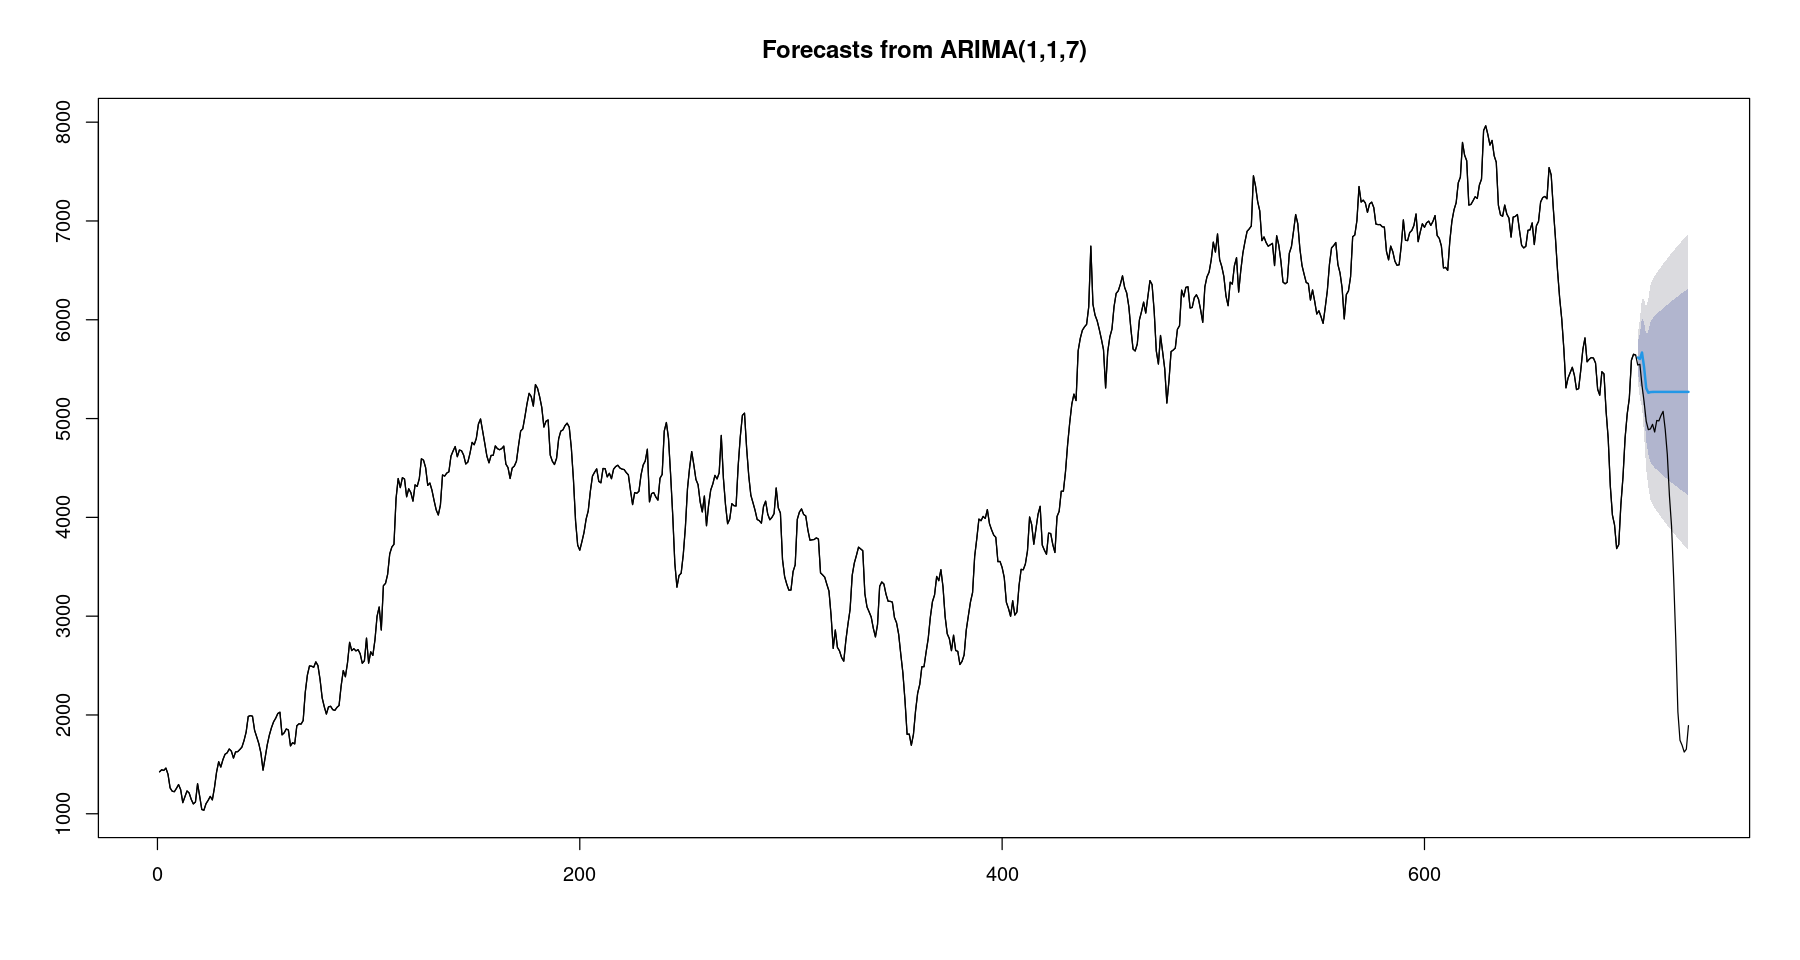

In [44]:
# przez parametr h deklarujemy, że chcemy przewidzieć 25 kroków do przodu
fcast <- forecast(model_2, h = 25)

plot(fcast)
lines(ts(deseasonal_cnt))

## Ewaluacja
W przypadku modelowania lub prognostyki, błąd szeregów czasowych określa się jako różnicę wartości przewidzianej przez model i wartości rzeczywistej. W tym celu możemy użyć dobrze znanych miar takich jak RMSE lub MAE.

In [47]:
suppressPackageStartupMessages(library(Metrics))

actual <- deseasonal_cnt[701:length(deseasonal_cnt)]
predicted <- fcast$mean

sprintf("RMSE = %.2f", rmse(actual, predicted))
sprintf("MAE = %.2f", mae(actual, predicted))

[1] "RMSE = 1876.37"

[1] "MAE = 1298.04"

## Podsumowanie
W tym materiale zostały omówione podstawy pracy z szeregami czasowymi. W celu poszerzenia wiedzy warto zapoznać się z następującymi zagadnieniami i modelami:
- time series cross-validation - wersja walidacji krzyżowej zachowująca chronologię obserwacji
- multivariate time series
- modele:
    - VARMA i VARMAX
    - ARCH i GARCH
    - Prophet
    - klasyczne modele (las losowy, XGBoost) i podejście głębokie (RNN, LSTM)